The Mesh
======

Underworld uses a mesh (grid) of nodes to solve the finite element (FE) variables on. These FE variables are examined in more detail in the next guide on **FE variables**. This notebook will go through a few different examples of what can be done with meshes using Underworld. 

**This notebook is broken down into the following examples:**

1. overview of meshes
2. setting and visualising up meshes
3. how to modify a mesh
4. loading and saving meshes
5. different mesh geometry types

**Keywords:** meshes, mesh geometry

**References**

1. Moresi, L., Dufour, F., Muhlhaus, H.B., 2002. Mantle convection modeling with viscoelastic/brittle lithosphere: Numerical methodology and plate tectonic modeling. Pure Appl. Geophys. 159 (10), 2335–2356.
2. Moresi, L., Dufour, F., Muhlhaus, H.B., 2003. A Lagrangian integration point finite element method for large deformation modeling of viscoelastic geomaterials. J. Comput. Phys. 184, 476–497.
3. Moresi, L., Quenette, S., Lemiale, V., Meriaux, C., Appelbe, B., Muhlhaus, H.-B., 2007. Computational approaches to studying non-linear dynamics of the crust and mantle. Physics of the Earth and Planetary Interiors 163, 69–82.


In [1]:
import underworld as uw
import glucifer.pylab as plt

Mesh overview
------

Underworld uses a modified finite element method which uses both a fixed background computational mesh and a collection of Lagrangian tracking points. The details of the implementation of the method are given in Moresi et al. (2002, 2003) and a summary of the approach taken by the Underworld code is given in Moresi et al. 2007. 

In the case of finite elements of implicit systems, a system needs to be represented both in a geometric (the mesh) and linear-systems (the matrix) sense. This means that finite element codes have heavy "book-keeping" requirements which are compounded when the code is run in parallel.

The division of the mesh across different computational nodes is handled through MPI calls underneath the Python layer of Underworld. The move into parallel is discussed in another user guide.


Setting up meshes
-----

**Create a mesh object**

The following command shows how to do create a mesh consiting of a ``res``$\times$``res`` cells of a particular configuration, in this case a linear, constant grid (``elementType = "Q1/dQ0"``). The spatial extent of the mesh will be the box height and length specified above. 

A visualisation of the mesh nodes for a single cell using the "Q1/dQ0" mesh type is shown below in 2D and 3D - see [here](http://femtable.org/) for a full list of element types and their naming convention. This elementType means that the primary mesh elements on the edges of the cell are in a "Q1" configuration, while the secondary (sub mesh) nodes are found inside the cell in a "dQ0" configuration.

![](Mesh_Q1dQ0.png)

Other ``elementTypes`` change the configuration of the mesh nodes around each cell and are examined in more detail at the end of this notebook.

For now we will step through what a mesh looks like. Firstly we will create a 2D mesh object with maximum coordinates of (1.0, 1.0) and a resolution of 4 $\times$ 4 cells. To create a 3D object add an extra term in the tuples for the ``elementRes``, ``minCoord`` and ``maxCoord``.

In [2]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (4, 4), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

**Plot representation of mesh**

To see what the mesh looks like we plot it using the ``.Mesh`` function in ``gLucifer``.

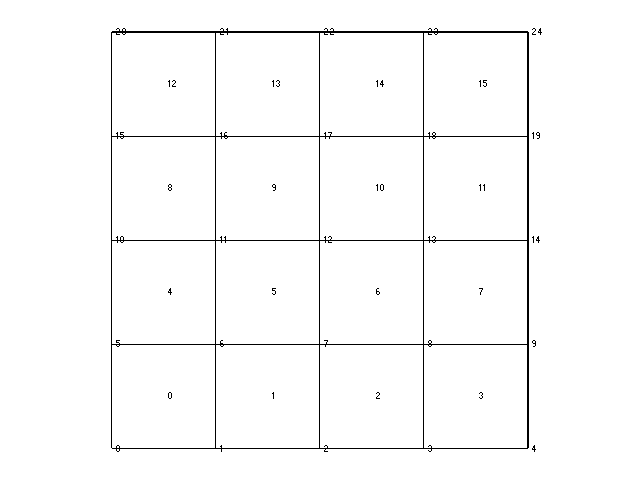

In [3]:
figMesh = plt.Figure()
figMesh.Mesh(mesh.subMesh, nodeNumbers=True, colourBar=False)
figMesh.Mesh(mesh, nodeNumbers=True, colourBar=False)
figMesh.show()

**Sub meshes**

The sub mesh is visible in the above figure via the index numbers inside each mesh cell. For reasons of numerical stability when solving the Stokes equations, the pressure field must be solved on a different mesh node configuration to the other fields. This configuration is accessed via the ``.subMesh`` function in underworld.

The sub mesh is only used for the pressure field since the pressure is evaluated inside the cell, whereas the temperature and velocity fields are evaluated on the edges. This means that the temperature and velocity field edges are the true simulation boundary, which is used when setting up boundary conditions (see the **Systems** guide).

For the newly created mesh object, the **main mesh (``Q1``) has node points on the edge of the cell** and is stored in the ``mesh`` object itself, while the **sub mesh (``dQ0``) has node points inside the cell** and stored in the ``mesh.subMesh`` object.  The list of spatial coordinates for each mesh node is stored in the ``.data`` method of the mesh or sub mesh object. 

Due to their different configurations, the total number of mesh points for the mesh and sub mesh are different. This can be demonstrated by looking at the lengths of the coordinate data arrays.

In [4]:
print(' Number of mesh points (Total) = {0:2d}'.format(len(mesh.data)))
print('      Number of submesh points = {0:2d}'.format(len(mesh.subMesh.data)))

 Number of mesh points (Total) = 25
      Number of submesh points = 16


In the above figure the large points are on the vertex node points for the ``elementMesh`` grid, while the smaller points denote the ``subMesh``. The larger mesh is used for the temperature and velocity fields, while the pressure field is used on the sub mesh. This example shows the ``elementType`` geometry of ``"Q1/dQ0"``, these are explained along with other mesh types below.

Modifying meshes
-----

Underworld supports irregular mesh geometries although only regular meshes are presently provided. This is important as it allows us to create custom meshes. For example the following cell creates a mesh which is exponentially spaced in the vertical direction, thus increasing the resolution at the top of the simulation domain.


In [5]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (8, 8), 
                                 minCoord    = (0.0, 0.0), 
                                 maxCoord    = (1.0, 1.0))

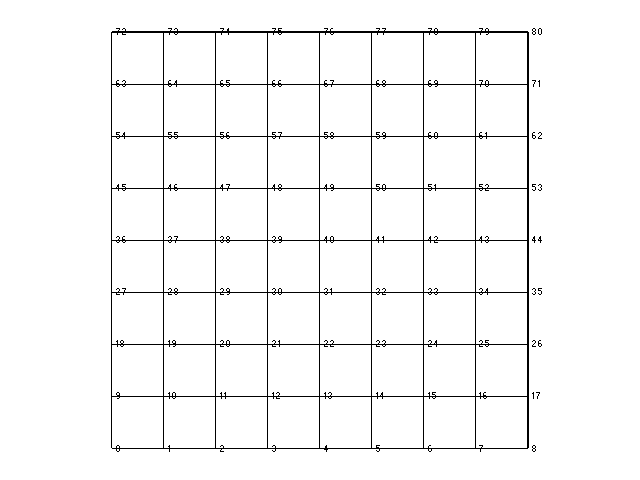

In [6]:
figMesh = plt.Figure()
figMesh.Mesh(mesh, nodeNumbers=True, colourBar=False)
figMesh.show()

By default the mesh data is read only. The following cell will unlock the mesh and displace a single node of the mesh in the positive x direction.

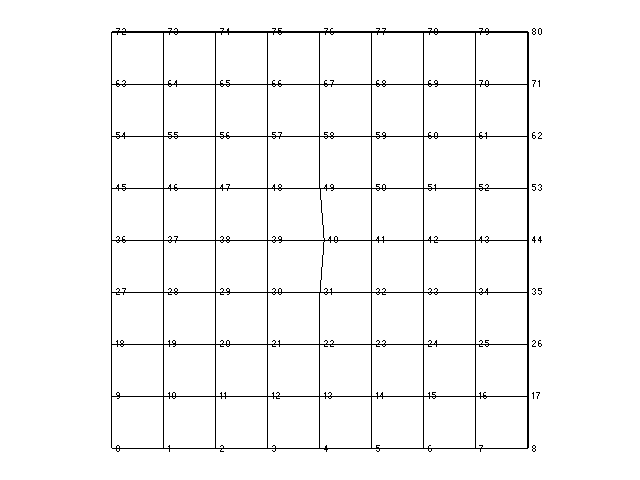

In [7]:
with mesh.deform_mesh():
    mesh.data[40][0] += 0.01
figMesh.show()

Deforming meshes allows us to increase resolution where it is needed most. For example at the top of the simulation domain by redefining the vertical mesh coordinate to be $z := 1-z^2$ 

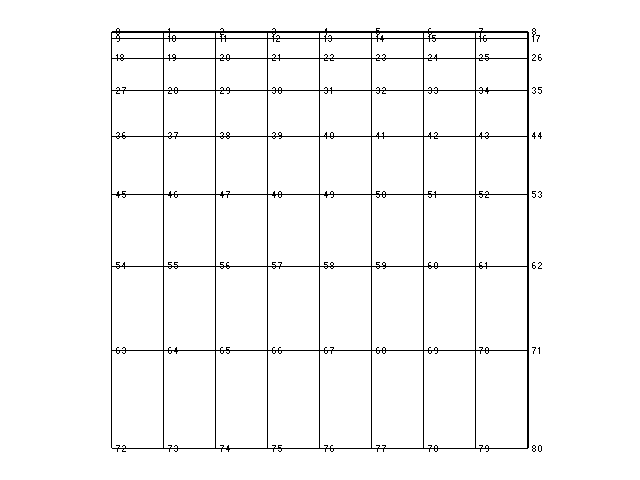

In [8]:
mesh.reset()  # restore the mesh to the original configuration specified by elementType
with mesh.deform_mesh():
    for index, coord in enumerate(mesh.data):
        mesh.data[index][1] = 1.0 - mesh.data[index][1]*mesh.data[index][1]
figMesh.show()

Saving and loading meshes
------

Mesh coordinate data can be saved in hdf5 format using the ``save`` method attached to the ``mesh`` class. The following line will save the mesh to a file.

In [9]:
mesh.save('deformedMesh.h5')

To check that this has worked we will re-create the mesh, plot and then reload the saved mesh.

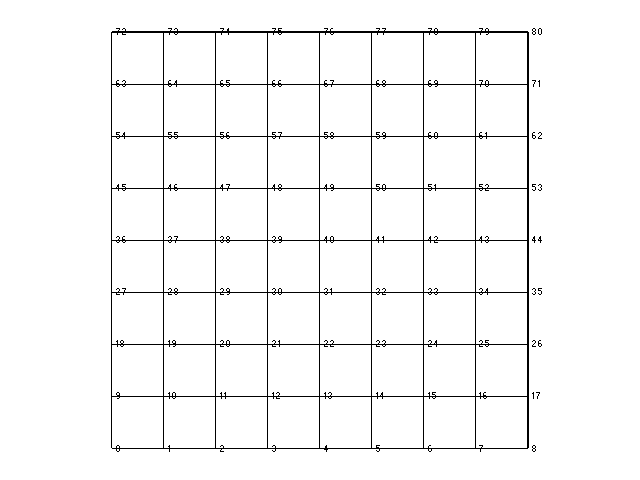

In [10]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (8, 8), 
                                 minCoord    = (0.0, 0.0), 
                                 maxCoord    = (1.0, 1.0))
figMesh = plt.Figure()
figMesh.Mesh(mesh, nodeNumbers=True, colourBar=False)
figMesh.show()

**Load mesh coming soon...**

Different types of mesh geometries
-----

Here we will examine the different mesh types that are available in ``underworld``.

The geometry of the mesh and subMesh is controlled from the ``elementType`` field in the mesh creation command. The mesh types are entered such that the first part is for the edge mesh, while the second part is for the sub mesh used by the pressure field. For example the ``Q1/dQ0`` mesh means that the edges of each rectangular cell use ``Q1`` and the sub mesh uses ``dQ0``. In particular this means that the are only nodes on the vertices of the edge mesh, and there is a single node in the centre of each cell. A full list of element types can be found [here](http://femtable.org/).

List of ``element types`` currently available in ``underworld``:

1. For the primary elementType: ``Q1`` or ``Q2``
2. For the secondary elementType: ``dQ0``, ``dQ1`` or ``dPC1``



Set up mesh with for a single cell in 3 dimensions.

In [11]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (1, 1, 1), 
                                 minCoord    = (0.0, 0.0, 0.0), 
                                 maxCoord    = (1.0, 1.0, 1.0))

Create swarms with particles on the mesh and sub mesh nodes. For more information on **swarms** see the user guide.

In [12]:
swarmMesh   = uw.swarm.Swarm( feMesh=mesh )
swarmCoords = mesh.data
swarmMesh.add_particles_with_coordinates(swarmCoords)
swarmSubMesh = uw.swarm.Swarm( feMesh=mesh )
swarmCoords  = mesh.subMesh.data
swarmSubMesh.add_particles_with_coordinates(swarmCoords)

array([0], dtype=int32)

Plot the mesh and sub mesh vertices with some aesthic changes for 3D visualisation. For more on visualising results in notebooks using Underworld see the **Visualisation with gLucifer** user guide.

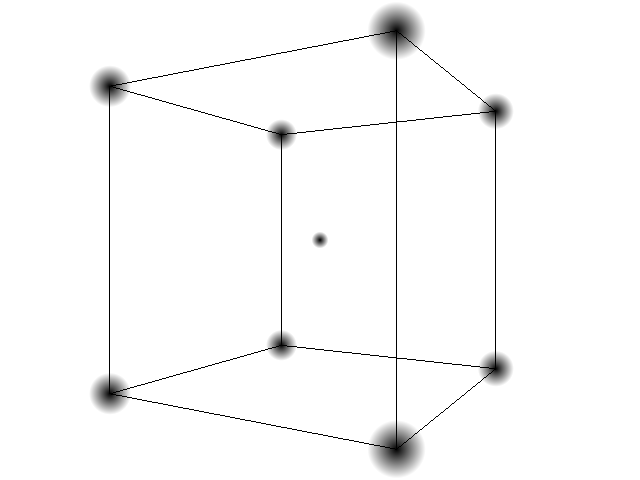

In [13]:
fig2 = plt.Figure()
fig2.Points( swarm=swarmMesh,    pointSize=50, colourBar = False )
fig2.Points( swarm=swarmSubMesh, pointSize=20, colourBar = False )
if(len(mesh.elementRes)==3):
    sc = fig2.script('rotate y -30')
    sc = fig2.script('zoom -0.1')
fig2.show()